<a href="https://colab.research.google.com/github/MasaAsami/ml-dae/blob/main/notebooks/dml_dea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 25.5 MB/s eta 0:00:00


# 直交化DEA : 特定inputに着目した効率性分析
- 普通のDEA、効率性分析はDMUそのものの効率性を調査する
- しかし、中には特定のinput(補助金や特定の費用)に着目して、各ユニットにおける当該inputの効率的使用に関心が向けられるケースもあるだろう（関心inputと呼ぶ）
- このとき、DEAのフレームワークをそのまま適用することは危険である。関心inputは、その他のinputと相関がある可能性がある。例えば、資本金に応じて補助金が配られている場合など
- 因果推論のターミノロジーを使えば、交絡である
- 本研究ではDML、つまりアウトカムに対するモデルと関心inputに対するモデルを別途構築し、直交化したうえで効率性分析を行うことを提唱する
- 直交化した後の関心inputとoutputについては、通常の効率性分析(DEAやSFAなど)を用いても構わない


In [3]:
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
import matplotlib.pyplot as plt


plt.style.use('ggplot')

import pandas as pd
import numpy as np
import numpy.random as rand


In [109]:
def gen_corr_data(x, rho_in=0.6, seed=1):
    np.random.seed(seed)
    size = len(x)
    _x = np.random.randn(size)
    return rho_in * x + (1 - rho_in ** 2) ** 0.5 * _x

In [188]:
SIZE = 1500
INPUT_DIM = 21
np.random.seed(0)
x = rand.randn(SIZE)
rho_list = np.random.uniform(-0.8, 0.3, INPUT_DIM -1)
df_list = []
df_list.append(x)
for i, _rho in enumerate(rho_list):
    df_list.append(
        gen_corr_data(x, rho_in=_rho, seed=i+1)
    )
df = pd.DataFrame(df_list).T
df.columns = ["input_{}".format(i) for i in range(INPUT_DIM)]
df = df.rename(columns={'input_0': 'target_input'})
other_input_cols = [_col for _col in df.columns if "input_" in _col]
df += 10
assert df.min().min() > 0

In [189]:
np.random.seed(0)
beta1_list = np.random.uniform(0.2, 1.0, INPUT_DIM)
beta2_list = np.random.uniform(0.05, 1.5, INPUT_DIM)
beta1_list[0] = 0 # 2.5
beta2_list[0] = 0 # 2.5

sim1_efficiency = np.random.normal(2.5, 0.1, SIZE)
sim2_efficiency = np.random.normal(2.5, 0.2, SIZE)

target1_effect = df["target_input"].values ** sim1_efficiency
target2_effect = df["target_input"].values ** sim2_efficiency

y1 = 10**(-15) * np.prod(df.values ** beta1_list, axis=1) * np.random.normal(1, 0.1, SIZE) * target1_effect
y2 = 10**(-18) * np.prod(df.values ** beta2_list, axis=1) * np.random.normal(1, 0.1, SIZE) * target2_effect


In [190]:
df["output_1"] = y1
df["output_2"] = y2
assert df.min().min() > 0

In [191]:
# Ground Truth
df["graund_truth_efficiency1"] = sim1_efficiency
df["graund_truth_efficiency2"] = sim2_efficiency

In [192]:
df.corr()

,target_input,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,...,input_15,input_16,input_17,input_18,input_19,input_20,output_1,output_2,graund_truth_efficiency1,graund_truth_efficiency2
target_input,1.000000,-0.790870,-0.159002,-0.657734,0.031312,-0.007686,-0.618280,0.235212,-0.016088,-0.432108,...,-0.084392,0.192622,-0.600973,0.127627,-0.763790,-0.179203,-0.219717,-0.170091,-0.003184,-0.016929
input_1,-0.790870,1.000000,0.127930,0.503019,-0.005329,-0.011000,0.508802,-0.185598,-0.006699,0.343590,...,0.053212,-0.169677,0.479770,-0.097040,0.587439,0.154919,0.230370,0.193346,-0.009120,0.015553
input_2,-0.159002,0.127930,1.000000,0.094216,-0.002317,-0.004992,0.107628,-0.021633,-0.034105,0.080231,...,-0.023995,-0.023285,0.114880,-0.030180,0.128418,0.022188,0.179105,0.220245,-0.029067,0.014162
input_3,-0.657734,0.503019,0.094216,1.000000,-0.017160,-0.014823,0.416868,-0.117192,0.022518,0.280622,...,0.076788,-0.123357,0.398011,-0.097200,0.486659,0.090865,0.229624,0.140899,0.014227,0.022324
input_4,0.031312,-0.005329,-0.002317,-0.017160,1.000000,0.014035,0.000323,-0.024126,-0.026308,0.007349,...,0.024723,0.005787,-0.023514,-0.006094,-0.020034,0.027166,0.105929,0.128108,-0.028817,-0.010158
input_5,-0.007686,-0.011000,-0.004992,-0.014823,0.014035,1.000000,0.015941,-0.030337,0.003822,0.026054,...,0.003733,0.004206,-0.001196,0.001679,0.016904,0.053046,0.202890,0.067461,0.036363,0.017021
input_6,-0.618280,0.508802,0.107628,0.416868,0.000323,0.015941,1.000000,-0.112528,0.001870,0.261355,...,0.053330,-0.117240,0.370792,-0.068334,0.475421,0.135779,0.237310,0.270218,-0.025479,0.031941
input_7,0.235212,-0.185598,-0.021633,-0.117192,-0.024126,-0.030337,-0.112528,1.000000,-0.011776,-0.099579,...,-0.004198,0.051621,-0.116519,0.059698,-0.172801,-0.046302,0.192145,0.100607,0.045773,0.010223
input_8,-0.016088,-0.006699,-0.034105,0.022518,-0.026308,0.003822,0.001870,-0.011776,1.000000,0.008894,...,-0.020249,-0.029400,0.027038,-0.003471,-0.013434,-0.027289,0.217245,0.079012,0.002801,0.005759
input_9,-0.432108,0.343590,0.080231,0.280622,0.007349,0.026054,0.261355,-0.099579,0.008894,1.000000,...,0.041107,-0.083857,0.274064,-0.067213,0.346203,0.093108,0.193870,0.140141,-0.003076,0.027048


In [193]:
from sklearn.model_selection import cross_val_predict
from lightgbm import LGBMRegressor
from sklearn.linear_model import LassoCV

In [194]:
df_model = df.assign(
            input_res=df['target_input']
            - cross_val_predict(
                LassoCV(cv=5, random_state=0), df[other_input_cols], df['target_input'], cv=2
            ),
            output1_res=df['output_1']
            - cross_val_predict(
                LGBMRegressor(random_state=0), df[other_input_cols], df['output_1'], cv=2
            ),
            output2_res=df['output_2']
            - cross_val_predict(
                LGBMRegressor(random_state=0), df[other_input_cols], df['output_2'], cv=2
            ),
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5020
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 20
[LightGBM] [Info] Start training from score 14.240198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [195]:
res_cols = [col for col in df_model.columns if "res" in col]
df_model[res_cols].corr()

,input_res,output1_res,output2_res
input_res,1.000000,0.303946,0.202015
output1_res,0.303946,1.000000,0.089825
output2_res,0.202015,0.089825,1.000000


## 直交化処理後の関心inputとoutcome

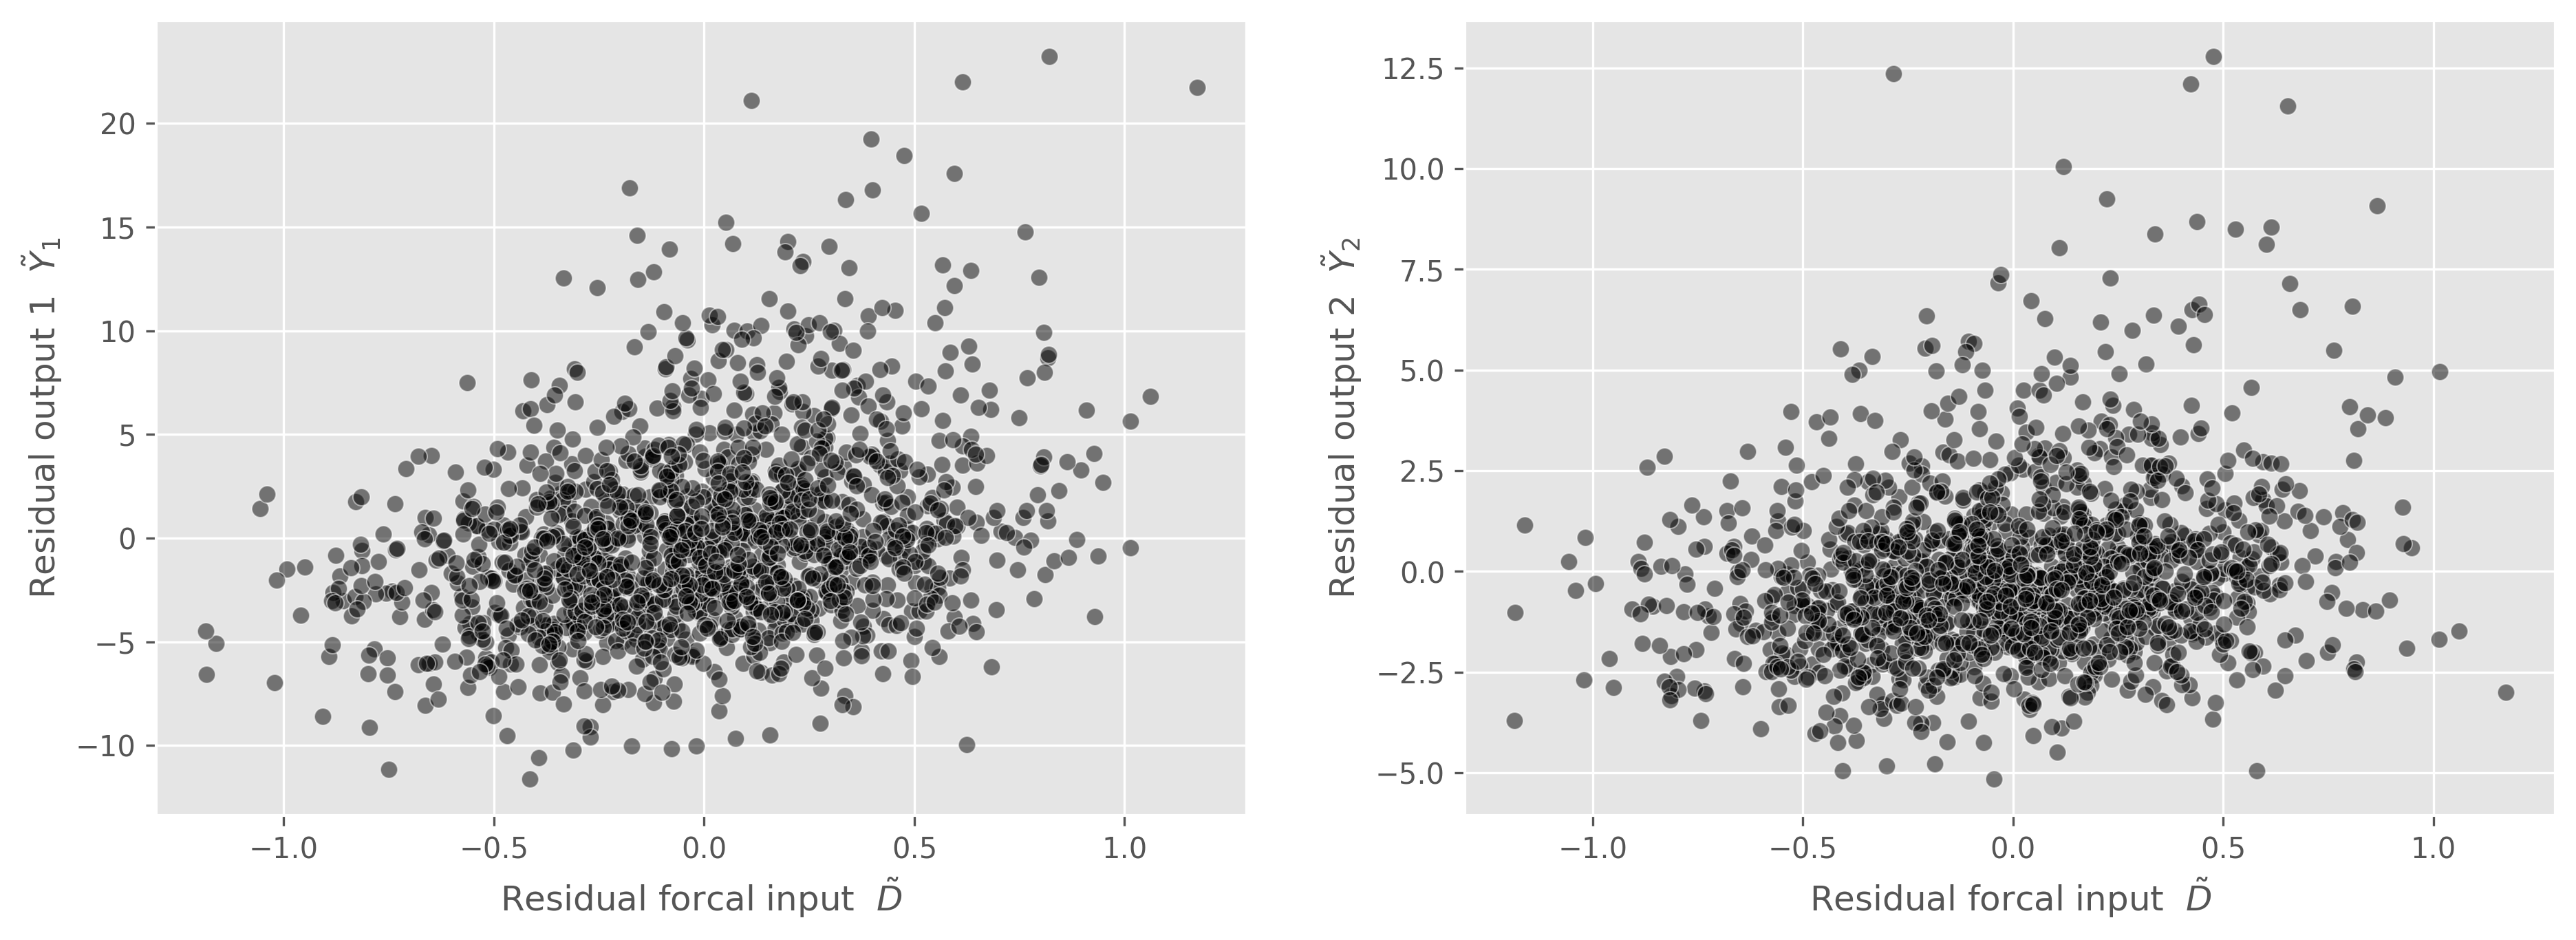

In [367]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

sns.scatterplot(
    data=df_model,
    x="input_res",
    y="output1_res",
    alpha = .5,
    ax=ax[0],
    color="black"
)
sns.scatterplot(
    data=df_model,
    x="input_res",
    y="output2_res",
    alpha = .5,
    ax=ax[1],
    color="black"
)
ax[0].set_xlabel(r"Residual forcal input  $\tilde{D}$")
ax[0].set_ylabel(r"Residual output 1  $\tilde{Y}_1$")
ax[1].set_xlabel(r"Residual forcal input  $\tilde{D}$")
ax[1].set_ylabel(r"Residual output 2  $\tilde{Y}_2$")

plt.show()

## 比較：関心inputとoutcomeの直接（ナイーブ）比較

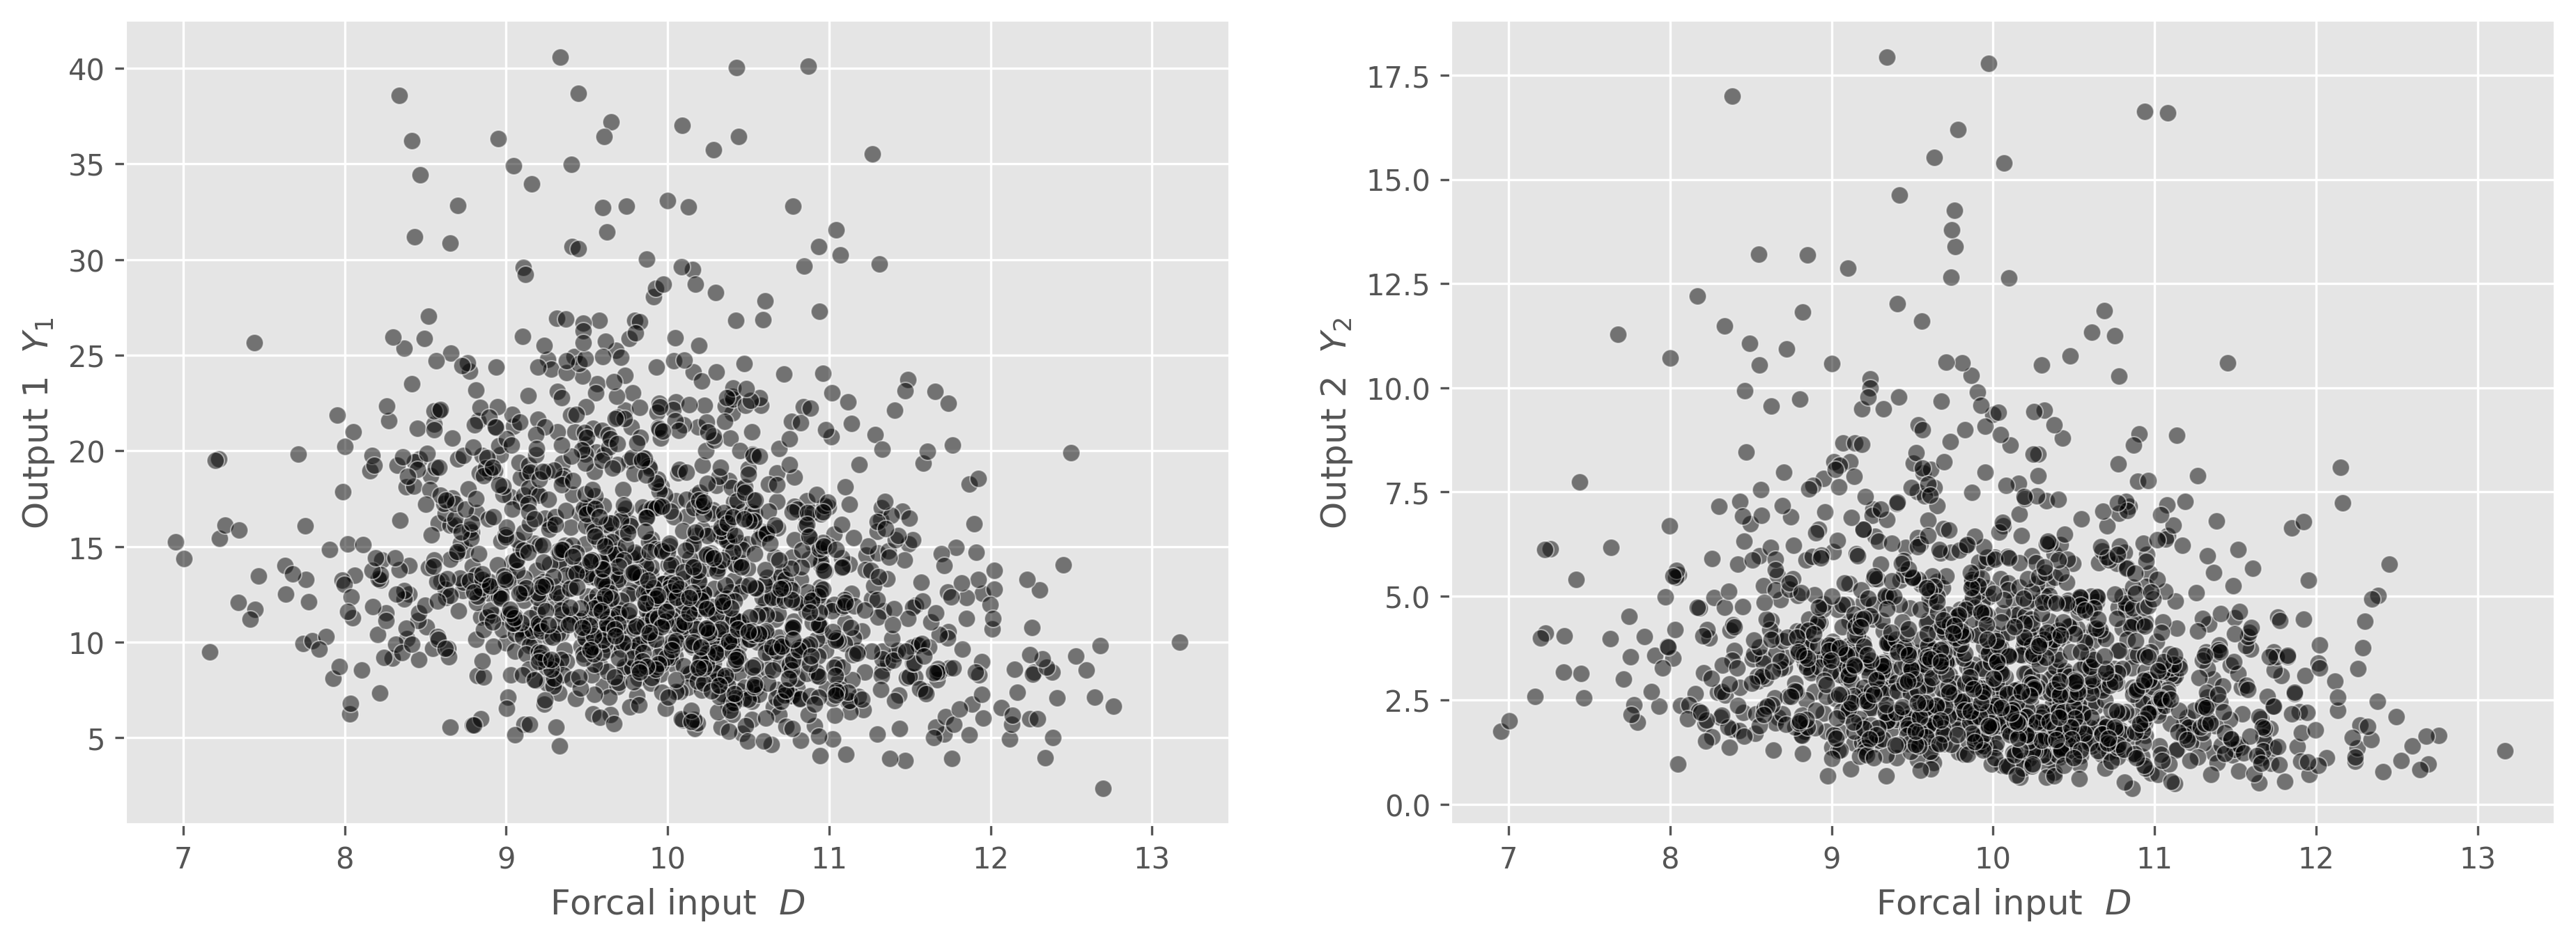

In [366]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

sns.scatterplot(
    data=df_model,
    x="target_input",
    y="output_1",
    alpha = .5,
    ax=ax[0],
    color="black"
)
sns.scatterplot(
    data=df_model,
    x="target_input",
    y="output_2",
    alpha = .5,
    ax=ax[1],
    color="black"
)

ax[0].set_xlabel(r"Forcal input  ${D}$")
ax[0].set_ylabel(r"Output 1  ${Y}_1$")
ax[1].set_xlabel(r"Forcal input  ${D}$")
ax[1].set_ylabel(r"Output 2  ${Y}_2$")

plt.show()

# confromal prediction as SFA
- 従来のSFAはモデルの仮定に頼りすぎている
- MLのconfromal predictionに閾値を決めて、それを効率フロンティアとしたほうがマシである
- ここでのDMU $i$ における効率性 $u_i$は以下の通りとする
$$
u_i = max( 1,  y_i/ \hat {y} ^{90tile}_i )
$$

In [198]:
from sklearn.model_selection import train_test_split
from mapie.regression import MapieQuantileRegressor

In [247]:
train_df, test_df = train_test_split(
    df_model, test_size=0.2, random_state=0
)

X_train, X_calib, y_train, y_calib = train_test_split(
    train_df[["input_res"]], train_df[["output1_res", "output2_res"]], test_size=0.1, random_state=1
)

In [248]:
sfa_model1 = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
)
sfa_model2 = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
)

In [249]:
%%time
mapie_model1 = MapieQuantileRegressor(
    sfa_model1,
    method='quantile',
    cv='split',
    alpha=0.1
)
mapie_model2 = MapieQuantileRegressor(
    sfa_model2,
    method='quantile',
    cv='split',
    alpha=0.1
)

mapie_model1.fit(
    X_train, y_train['output1_res'],
    X_calib = X_calib, y_calib = y_calib['output1_res'],
    random_state=0
)

mapie_model2.fit(
    X_train, y_train['output2_res'],
    X_calib = X_calib, y_calib = y_calib['output2_res'],
    random_state=0
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1080, number of used features: 1
[LightGBM] [Info] Start training from score -6.172489
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 1080, number of used features: 1
[LightGBM] [Info] Start training from score 8.382643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the trai

MapieQuantileRegressor(cv='split',
                       estimator=LGBMRegressor(alpha=0.5, objective='quantile'))

In [250]:
_, test_pred1 = mapie_model1.predict(test_df[["input_res"]])
_, test_pred2 = mapie_model2.predict(test_df[["input_res"]])
test_df["pred_frontier1"] = test_pred1[:, 1, 0]
test_df["pred_frontier2"] = test_pred2[:, 1, 0]

In [251]:

w1 = np.polyfit(test_df["input_res"] , test_df["pred_frontier1"], 3)
w2 = np.polyfit(test_df["input_res"] , test_df["pred_frontier2"], 3)
test_df["pred_frontier1_smooth"] = np.polyval(w1,test_df["input_res"])
test_df["pred_frontier2_smooth"] = np.polyval(w2,test_df["input_res"])

In [252]:
w1 = np.polyfit(test_df["input_res"] , test_df["pred_frontier1"], 3)

ys = np.polyval(w1,test_df["input_res"])

In [253]:


test_df["pred_efficiency1"] = np.where(
    test_df["output1_res"] / test_df["pred_frontier1_smooth"] > 1 ,
    1,
    test_df["output1_res"] / test_df["pred_frontier1_smooth"]
)
test_df["pred_efficiency2"] = np.where(
    test_df["output2_res"] / test_df["pred_frontier2_smooth"] > 1 ,
    1,
    test_df["output2_res"] / test_df["pred_frontier2_smooth"]
)


In [254]:
from scipy.stats import spearmanr
corr_1, p_value1 = spearmanr(test_df["graund_truth_efficiency1"], test_df["pred_efficiency1"])
corr_2, p_value2 = spearmanr(test_df["graund_truth_efficiency2"], test_df["pred_efficiency2"])

print(f"corr (graund truth efficiency on output 1) {corr_1 : .3f}, p-value {p_value1 :.5f}")
print(f"corr (graund truth efficiency on output 2) {corr_2 : .3f}, p-value {p_value2 :.5f}")

corr (graund truth efficiency on output 1)  0.722, p-value 0.00000
corr (graund truth efficiency on output 2)  0.774, p-value 0.00000


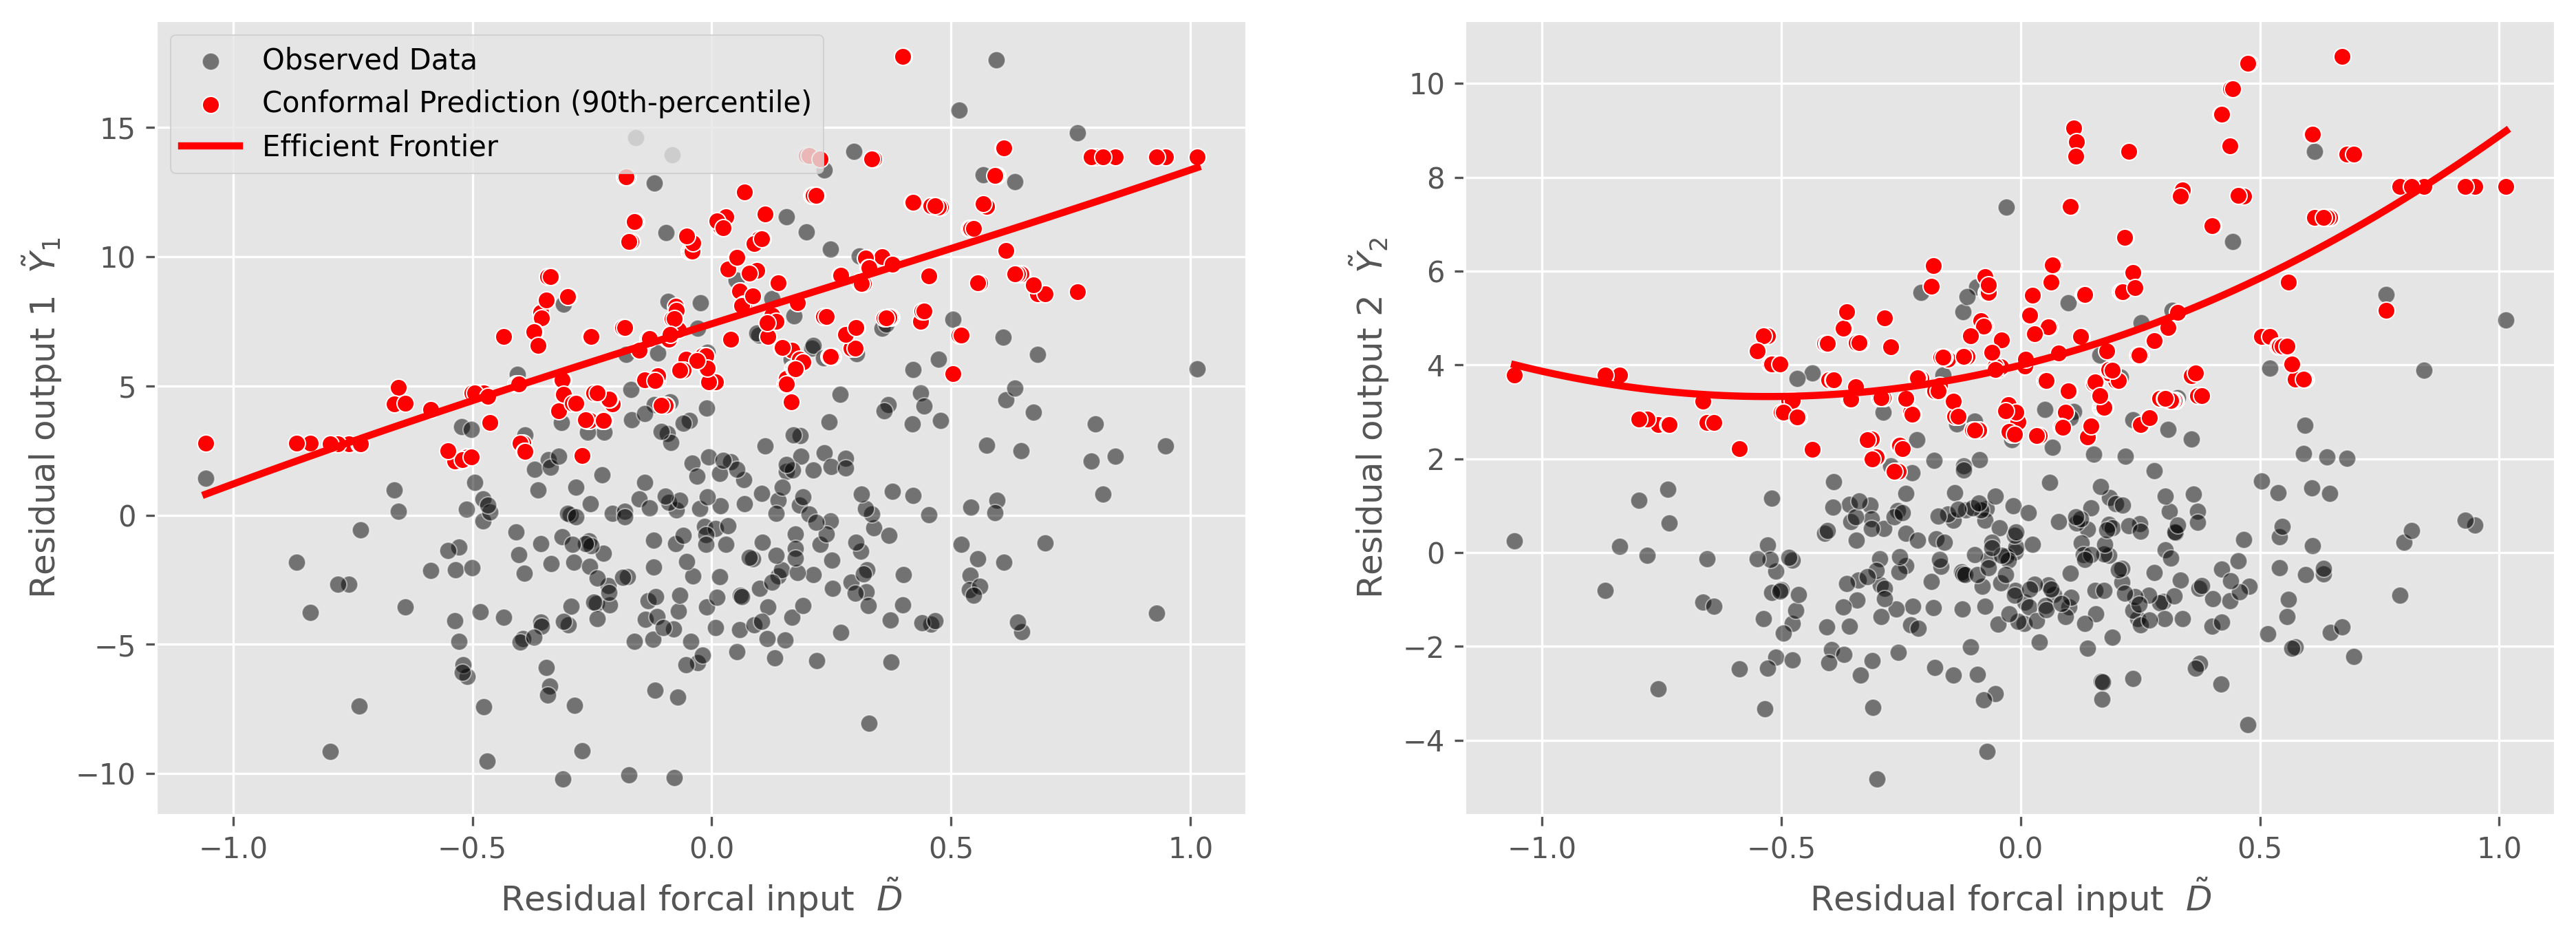

In [255]:
xx = np.linspace(test_df["input_res"].min(), test_df["input_res"].max(), 100)


fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

sns.scatterplot(
    data=test_df,
    x="input_res",
    y="output1_res",
    alpha =0.5,
    ax=ax[0],
    color="black",
    label='Observed Data'
)
sns.scatterplot(
    data=test_df,
    x="input_res",
    y="pred_frontier1",
    alpha = 1,
    ax=ax[0],
    color="red",
    label='Conformal Prediction (90th-percentile)'
)
sns.lineplot(
    x=xx,
    y=np.polyval(w1,xx),
    ax=ax[0],
    palette="rocket",
    color="red",
    linewidth=2.5,
    label='Efficient Frontier'
)

sns.scatterplot(
    data=test_df,
    x="input_res",
    y="output2_res",
    alpha =0.5,
    ax=ax[1],
    color="black"
)
sns.scatterplot(
    data=test_df,
    x="input_res",
    y="pred_frontier2",
    alpha = 1,
    ax=ax[1],
    color="red"
)
sns.lineplot(
    x=xx,
    y=np.polyval(w2,xx),
    ax=ax[1],
    palette="rocket",
    color="red",
    linewidth=2.5,
)

ax[0].set_xlabel(r"Residual forcal input  $\tilde{D}$")
ax[0].set_ylabel(r"Residual output 1  $\tilde{Y}_1$")
ax[1].set_xlabel(r"Residual forcal input  $\tilde{D}$")
ax[1].set_ylabel(r"Residual output 2  $\tilde{Y}_2$")


plt.show()

# DEA : 1 input vs. 2 output形式
- 直交化した後で、通常のDEAにかけることも可能

In [297]:
def zscore(x,):
    xmean = x.mean()
    xstd  = x.std()
    zscore = (x-xmean)/xstd
    return zscore

dea_df = df_model[["input_res", "output1_res", "output2_res"]]
for _col in dea_df.columns:
    dea_df[_col] = zscore(dea_df[_col])
    dea_df[_col] += dea_df[_col].min()*-1 + 1

dea_df["retio_1"] = dea_df["output1_res"] / dea_df["input_res"]
dea_df["retio_2"] = dea_df["output2_res"] / dea_df["input_res"]

In [298]:
retio95_1 = dea_df["retio_1"].quantile(0.90)
retio95_2 = dea_df["retio_2"].quantile(0.90)

dea_df = dea_df.query("retio_1 <= @retio95_1 and retio_2 <= @retio95_2").sample(50, random_state=0)

In [299]:
import numpy as np
from scipy.optimize import fmin_slsqp
from multiprocessing import Pool
from tqdm import tqdm

def optimize_one_unit(args):
    inputs, outputs, unit, m, r, n = args

    def target(x):
        in_w, out_w, lambdas = x[:m], x[m:m + r], x[m + r:]
        denominator = np.dot(inputs[unit], in_w)
        numerator = np.dot(outputs[unit], out_w)
        return numerator / denominator

    def constraints(x):
        in_w, out_w, lambdas = x[:m], x[m:m + r], x[m + r:]
        t = target(x)
        constr = []

        for i in range(m):
            lhs = np.dot(inputs[:, i], lambdas)
            constr.append(t * inputs[unit, i] - lhs)

        for o in range(r):
            lhs = np.dot(outputs[:, o], lambdas)
            constr.append(lhs - outputs[unit, o])

        for u in range(n):
            constr.append(lambdas[u])

        return np.array(constr)

    d0 = m + r + n
    x0 = np.random.rand(d0) - 0.5
    result = fmin_slsqp(target, x0, f_ieqcons=constraints, disp=False)
    in_w, out_w = result[:m], result[m:m + r]
    denominator = np.dot(inputs, in_w)
    numerator = np.dot(outputs, out_w)
    return (numerator / denominator)[unit]


class DEA(object):

    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

        self.n = inputs.shape[0]
        self.m = inputs.shape[1]
        self.r = outputs.shape[1]

        self.unit_ = range(self.n)
        self.input_ = range(self.m)
        self.output_ = range(self.r)

        self.output_w = np.zeros((self.r, 1), dtype=float)
        self.input_w = np.zeros((self.m, 1), dtype=float)
        self.lambdas = np.zeros((self.n, 1), dtype=float)
        self.efficiency = np.zeros_like(self.lambdas)

        self.names = []

    def __optimize(self):
        args = [(self.inputs, self.outputs, unit, self.m, self.r, self.n) for unit in self.unit_]
        with Pool() as pool:
            results = list(tqdm(pool.imap(optimize_one_unit, args), total=self.n, desc="Optimizing DEA"))
        self.efficiency = np.array(results).reshape(-1, 1)

    def name_units(self, names):
        assert self.n == len(names)
        self.names = names

    def fit(self):
        self.__optimize()


In [300]:
dea = DEA(
    dea_df[["input_res"]].to_numpy(),
    dea_df[["output1_res", "output2_res"]].to_numpy()
)
dea.name_units(list(dea_df.index))
dea.fit()
dea_df["dea_efficiency"] = dea.efficiency

Optimizing DEA: 100%|██████████| 50/50 [00:02<00:00, 23.56it/s]


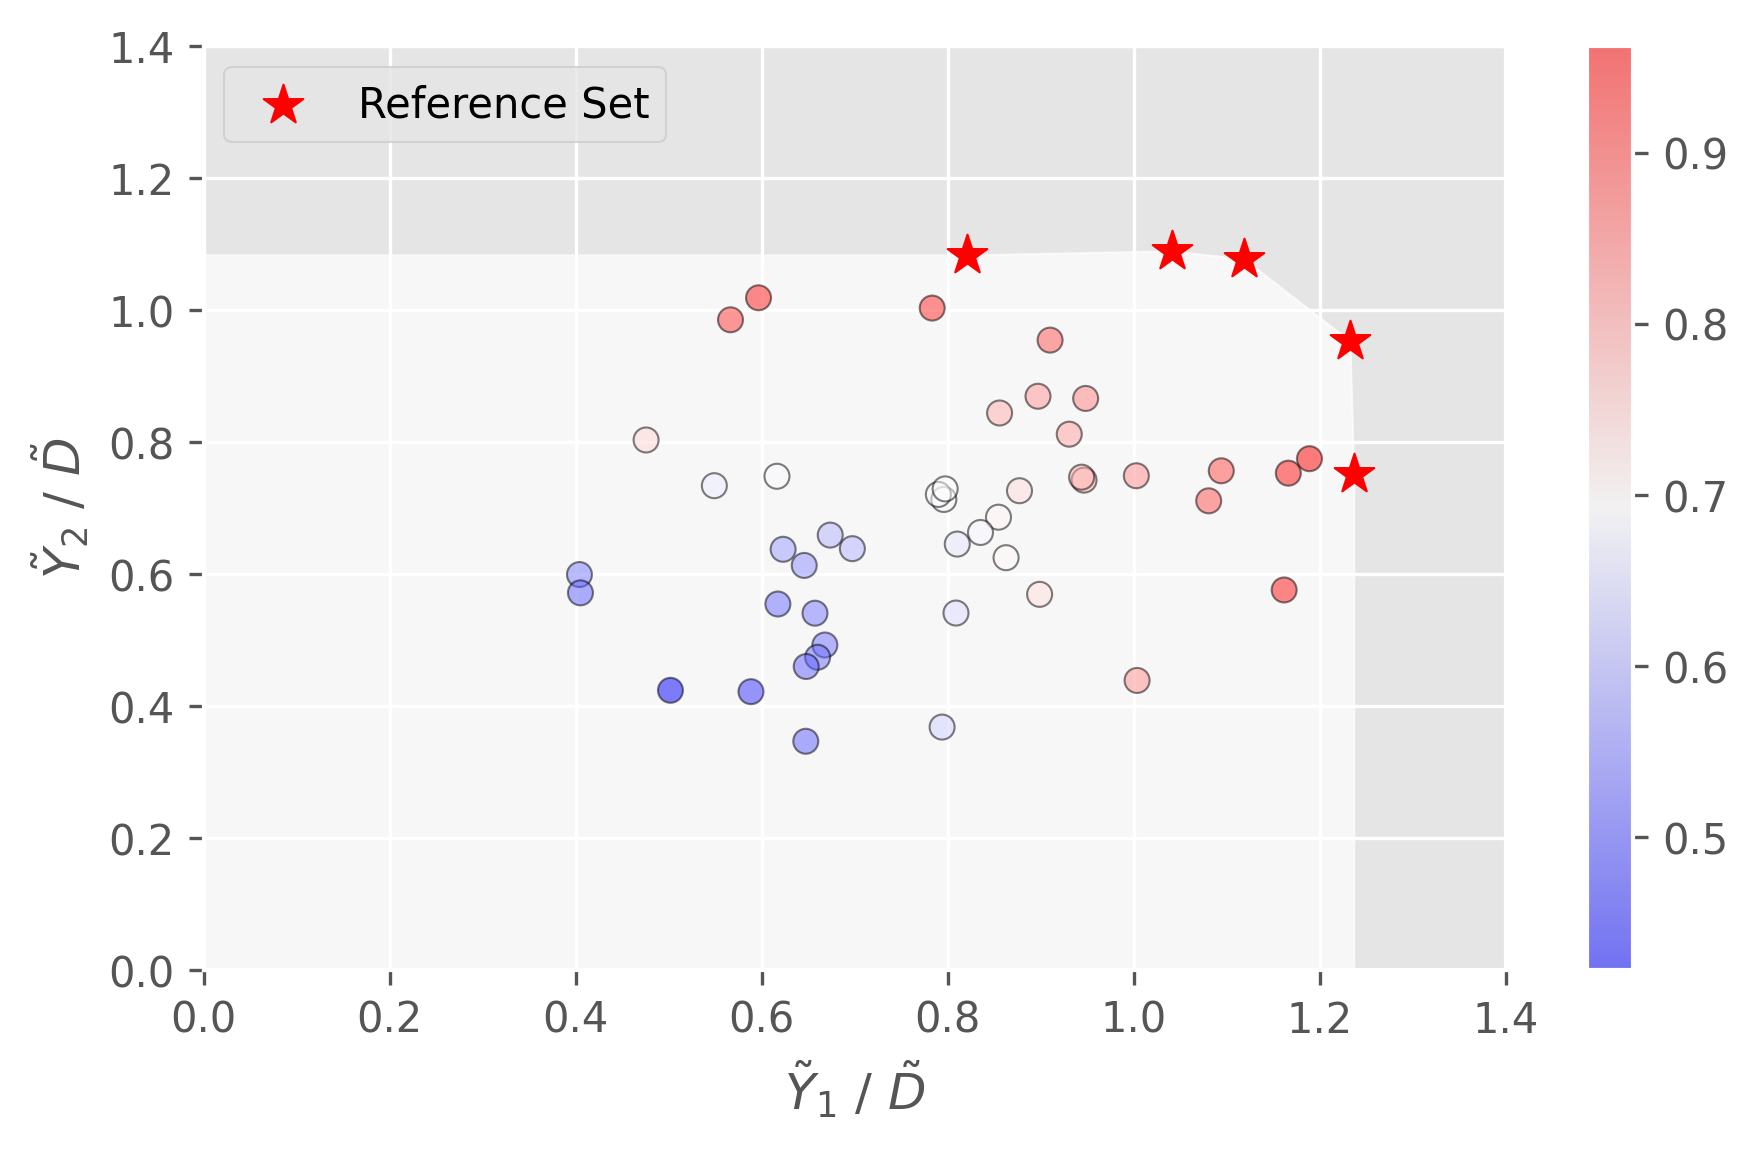

In [363]:
subset_efficent = dea_df.query("dea_efficiency > 0.99").sort_values("retio_1", ascending=True)
fill_x = [0] + subset_efficent["retio_1"].to_list()
fill_y = [subset_efficent.iloc[0]["retio_2"]] + subset_efficent["retio_2"].to_list()

fig = plt.figure(figsize=(7, 4), dpi=300)
plt.fill_between(fill_x, 0, fill_y, color='w', alpha=.7)
plt.scatter(
    subset_efficent.retio_1,
    subset_efficent.retio_2,
    s=100,
    alpha = 1,
    marker="*",
    c="r",
    label='Reference Set'
)

plt.scatter(
    dea_df.query("dea_efficiency < 0.99").retio_1,
    dea_df.query("dea_efficiency < 0.99").retio_2,
    alpha = .5,
    c = dea_df.query("dea_efficiency < 0.99").dea_efficiency,
    cmap = 'bwr',
    edgecolors="black",
)
cbar = plt.colorbar()


plt.xlabel(r"$\tilde{Y}_1$ / $\tilde{D}$")
plt.ylabel(r"$\tilde{Y}_2$ / $\tilde{D}$")
plt.grid(True)
plt.xlim(0, 1.4)
plt.ylim(0, 1.4)
plt.legend(loc = "upper left")
plt.show()